<a href="https://colab.research.google.com/github/rodrigonavas/Arbol-de-decision-sklearn/blob/master/Arbol_de_decisi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejercicio de árbol binario con un dataset de supervivientes del Titanic

Descripción de los campos:

| Variable |	Definición | Llave |
| -- | -- | -- |
| survival |	Sobrevivió |	0 = No, 1 = Si |
| pclass |	Clase del ticket |	1 = 1ra, 2 = 2da, 3 = 3ra |
| sex |	Género	 | |
| Age |	Edad en años	| |
| sibsp	| # de hermanos / conyuges abordo del Titanic	| |
| parch	| # de padres / hijos abordo del Titanic | |
| ticket	| Número de ticket	| |
| fare | Tarifa pagada | |
| cabin |	Número de cabina	| |
| embarked |	Puerto de embarque |	C = Cherbourg, Q = Queenstown, S = Southampton |

Librerias necesarias para el ejercicio

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pydotplus
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from io import StringIO
from IPython.display import Image, display

%matplotlib inline
sns.set()
out = StringIO()

###URLs donde se aloja los datos en formato .csv
Un archivo contiene los datos de entramiento y el otro los datos para realizar las pruebas

In [8]:
url_titanic = "https://raw.githubusercontent.com/terranigmark/curso-analisis-exploratorio-datos-platzi/main/train_titanic.csv"

Se transforman los datos de entrenamientro a un Dataset de pandas y se pintan lo primeros 5 registros como ejemplo

In [11]:
df_titanic = pd.read_csv(url_titanic, error_bad_lines = False)
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Se pintan los datos y sus tipos

In [12]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Visualización de la cantidad de pasajeros separada por género

Text(0.5, 1.0, 'Distribución de sobrevivientes')

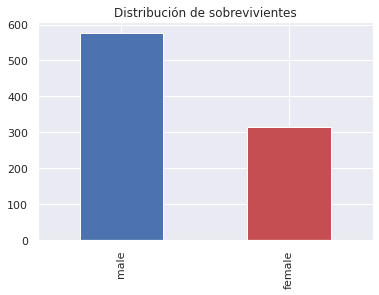

In [14]:
df_titanic.Sex.value_counts().plot(kind='bar', color=['b','r'])
plt.title('Distribución de sobrevivientes')

Se utiliza la función de prepocesamiento para limpiar la columna de Género

In [17]:
label_encoder = preprocessing.LabelEncoder()
enconder_sex = label_encoder.fit_transform(df_titanic['Sex'])
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Para trabajar correctamente con datos nulos, utilizando la media para rellenar si un registro no tiene campo "Edad"

In [19]:
df_titanic['Age'] = df_titanic['Age'].fillna(df_titanic['Age'].median())

Por defecto se colocara Southampton en los nulos


In [18]:
df_titanic['Embarked'] = df_titanic['Embarked'].fillna('S')

Se desechan los atributos que no son importante para la construcción del árbol de decisión

In [32]:
train_predictors = df_titanic.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)
train_predictors.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

Se declaran variables categoricas aquellas que tengan valores únicos menores de 10 y que sean de tipo 'object' (no numérico)

In [24]:
categorial_cols = [cname for cname in train_predictors if 
                    train_predictors[cname].nunique() < 10 and 
                    train_predictors[cname].dtype == 'object'
                  ]
categorial_cols                  

['Sex', 'Embarked']

Se declaran variables numéticas aquellas que sean de tipo Entero o Flotante

In [28]:
numerical_cols = [cname for cname in train_predictors.columns if
                    train_predictors[cname].dtype in ['int64', 'float64']
                 ]
numerical_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Las variables depuradas se unen de neuvo en un DataFrame y se pintan las primeras 5 como ejemplo

In [34]:
my_cols = categorial_cols + numerical_cols
train_predictors = train_predictors[my_cols]
train_predictors.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,S,3,22.0,1,0,7.2500
1,female,C,1,38.0,1,0,71.2833
2,female,S,3,26.0,0,0,7.9250
3,female,S,1,35.0,1,0,53.1000
4,male,S,3,35.0,0,0,8.0500


Se generan datos de prueba con base en la información depurada anterioresmente, con una función específica de Pandas

In [37]:
dummy_encoded_train_predictors = pd.get_dummies(train_predictors)
dummy_encoded_train_predictors.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Se seleccionan los valores de y que por objetivo, en este caso es el campo de Sobrevivió y se obtinenen los atributos seleccionados 

In [38]:
y_target = df_titanic['Survived'].values
selected_atributes = dummy_encoded_train_predictors.values

Se separa el data en un X (los atributos seleccionados) y Y (el campo "Sobrevivió") en datos de entrenamiento y en datos de validación, cona relación de 75 a 25 reespectivamente

In [45]:
x_train, x_validation, y_train, y_validation = train_test_split(
    selected_atributes, y_target, test_size = 0.25, random_state = 1)

Se procede a entrenar el árbol con los datos de entrenamiento

In [46]:
tree_one = tree.DecisionTreeClassifier()
tree_one = tree_one.fit(x_train, y_train)

Se utilizan los datos de validación para calcular el porcentaje de precisión del árbol entrenado para predecir los resultados

In [57]:
tree_one_accuracy = round(tree_one.score(x_validation, y_validation), 5)
print(f'Precisión del árbol: {tree_one_accuracy * 100} %')

Precisión del árbol: 74.439 %


Se guarda el árbol en formato png

In [56]:
tree.export_graphviz(tree_one, out_file=out)
graph = pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png('Árbol_de_decisión.png')

True

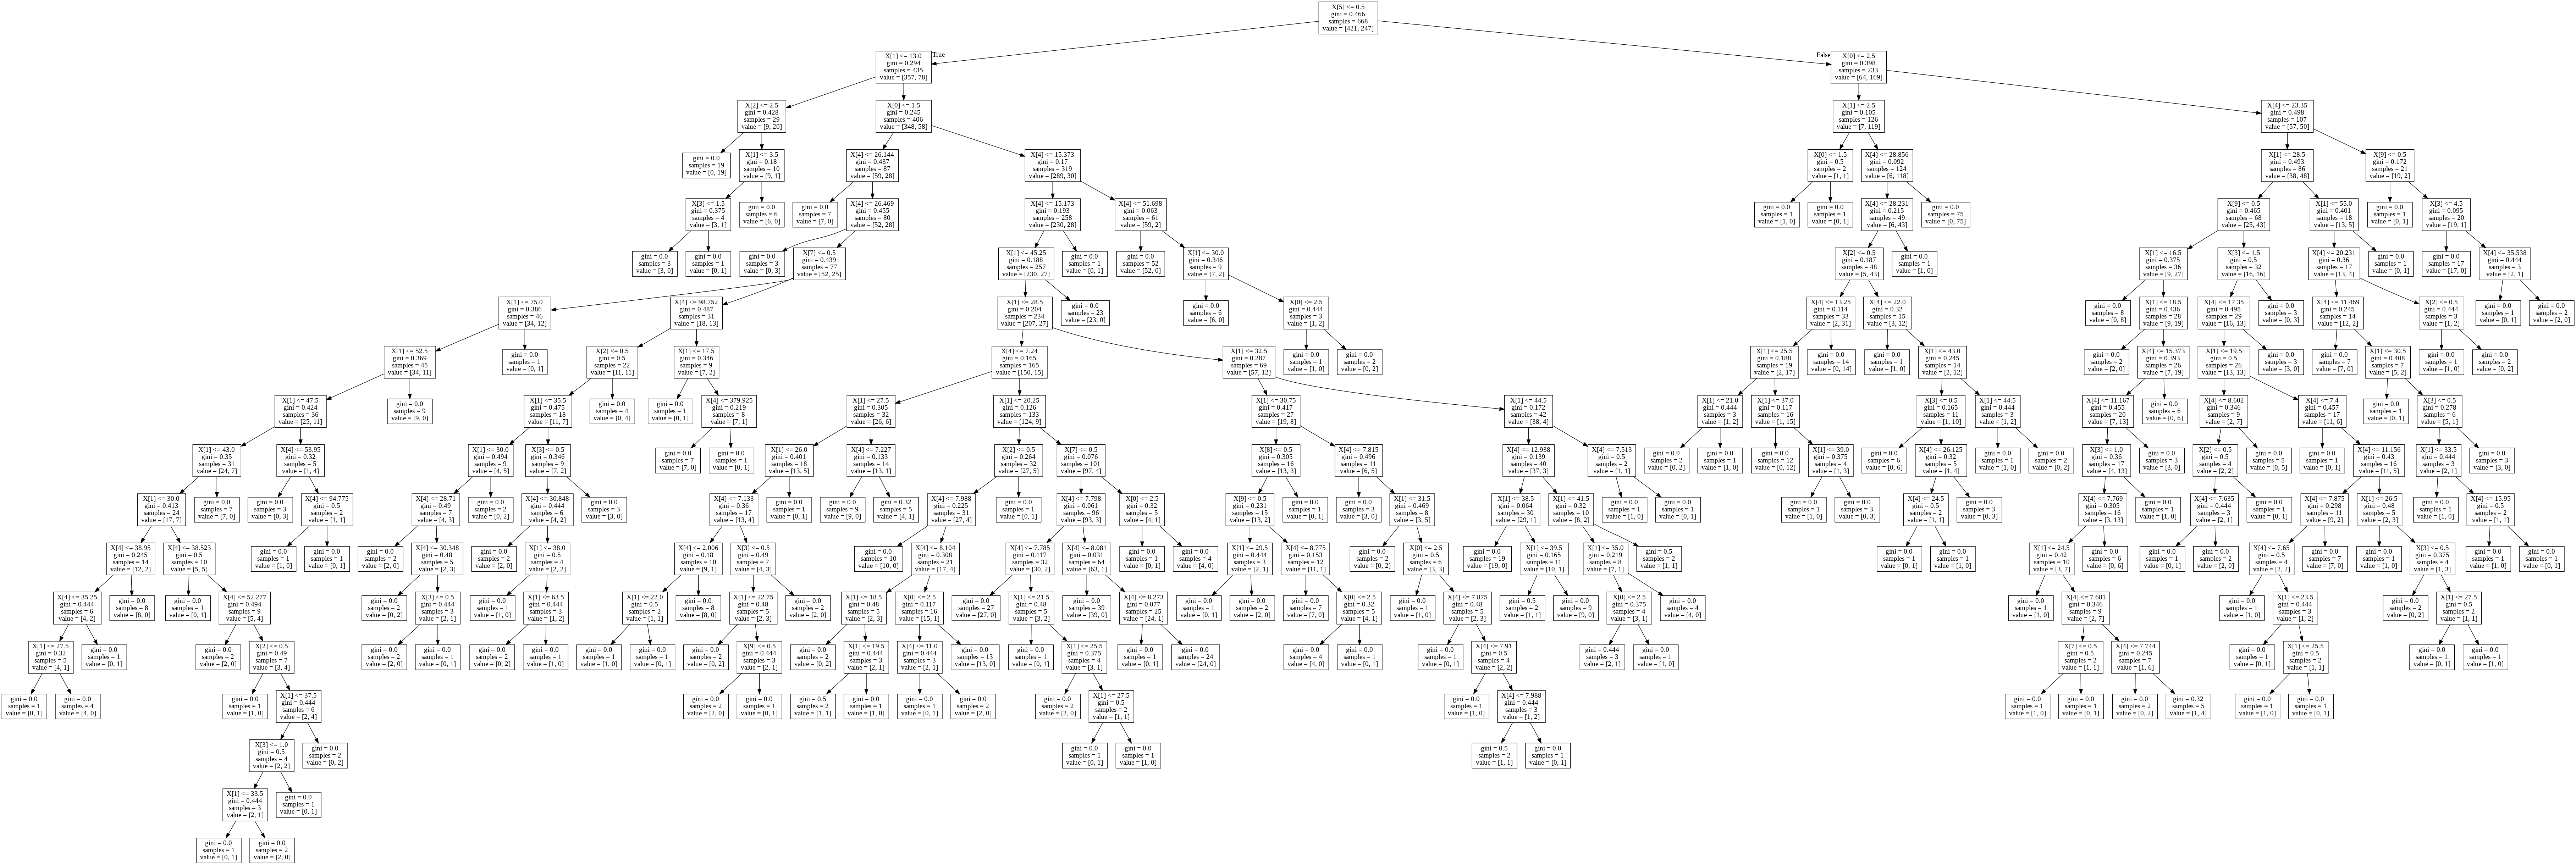

In [58]:
display(Image('Árbol_de_decisión.png'))